In [34]:
import sklearn
import scipy
import plotly 
import matplotlib as plt
import numpy as np
import pickle
import json
import plotly.graph_objects as go


import nest


nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 10})


In [35]:
# nest.GetKernelStatus()

In [36]:
json_file_path = "M1_Params.json"

# Load the JSON data into a Python dictionary
with open(json_file_path, "r") as json_file:
    ctxM1Params = json.load(json_file)

In [37]:
M1_structure_info=ctxM1Params['M1']['structure_info']
M1_neuron_info=ctxM1Params['M1']['neuro_info']
M1_neuron_l1=M1_neuron_info['L1']
M1_neuron_l23=M1_neuron_info['L23']
M1_neuron_l5a=M1_neuron_info['L5A']
M1_neuron_l5b=M1_neuron_info['L5B']
M1_neuron_l6=M1_neuron_info['L6']
M1_connection_info=ctxM1Params['M1']['connection_info']

In [38]:
M1_neuron_l1

{'SBC': {'neuron_model': 'iaf_cond_alpha',
  'EorI': 'I',
  'membrane_time_constant': 10.0,
  'spike_threshold': -50.0,
  'reset_value': -70.0,
  'E_rest': -70.0,
  'I_ex': 0.0,
  'absolute_refractory_period': 1.0,
  'E_ex': 0.0,
  'E_in': -80.0,
  'tau_syn_ex': 0.5,
  'tau_syn_in': 3.33,
  'Cellcount_mm2': 1187.9934,
  'n_type_index': 0},
 'ENGC': {'neuron_model': 'iaf_cond_alpha',
  'EorI': 'I',
  'membrane_time_constant': 10.0,
  'spike_threshold': -50.0,
  'reset_value': -70.0,
  'E_rest': -70.0,
  'I_ex': 0.0,
  'absolute_refractory_period': 1.0,
  'E_ex': 0.0,
  'E_in': -80.0,
  'tau_syn_ex': 0.5,
  'tau_syn_in': 3.33,
  'Cellcount_mm2': 611.9966,
  'n_type_index': 1}}

In [39]:
M1_layer_depth =M1_structure_info['layer_depth']
M1_layer_thickness=M1_structure_info['layer_thickness']
M1_region_size=M1_structure_info['region_size']
area_xy = [1.0, 1.0]
np.random.seed(42)

# # def neuron_pos(layer_index, neuron_info):
    
# #     z_start = M1_layer_depth[layer_index]
# #     z_end = M1_layer_depth[layer_index + 1]
# #     n_count = int(neuron_info['Cellcount_mm2'])
# #     x = np.random.uniform(0, M1_region_size[0], n_count)
# #     y = np.random.uniform(0, M1_region_size[1], n_count)
# #     z = np.random.uniform(z_start, z_end, n_count)
# #     pos = np.stack([x, y, z], axis=1)
# #     # print(pos)

# #     # spatial_pos = nest.spatial.free(pos.tolist())
# #     return pos

# # M1_neuron_l1_pos = neuron_pos(0)
# # M1_neuron_l23_pos = neuron_pos(1)
# # M1_neuron_l5a_pos = neuron_pos(2)
# # M1_neuron_l5b_pos = neuron_pos(3)
# # M1_neuron_l6_pos = neuron_pos(4)


# def neuron_pos(layer_index, neuron_info):
#     z_start = M1_layer_depth[layer_index]
#     z_end = M1_layer_depth[layer_index + 1]
#     n_count = int(neuron_info['Cellcount_mm2'])
    
    
#     grid_size = int(np.ceil(np.sqrt(n_count)))  
#     x_lin = np.linspace(0, M1_region_size[0], grid_size)
#     y_lin = np.linspace(0, M1_region_size[1], grid_size)
#     z_lin = np.linspace(z_start, z_end, grid_size)

#     x_grid, y_grid, z_grid = np.meshgrid(x_lin, y_lin, z_lin)
#     positions = np.column_stack([x_grid.ravel(), y_grid.ravel(), z_grid.ravel()])

#     # np.random.shuffle(positions)  

#     pos = positions[:n_count]

#     return pos

def neuron_pos(layer_index, neuron_info):
    z_start = M1_layer_depth[layer_index]
    z_end = M1_layer_depth[layer_index + 1]
    n_count = int(neuron_info['Cellcount_mm2'])  
    
    grid_size = int(round(n_count ** (1/3)))  
    

    x_lin = np.linspace(0, M1_region_size[0], grid_size)
    y_lin = np.linspace(0, M1_region_size[1], grid_size)
    z_lin = np.linspace(z_start, z_end, grid_size)


    x_grid, y_grid, z_grid = np.meshgrid(x_lin, y_lin, z_lin)
    positions = np.column_stack([x_grid.ravel(), y_grid.ravel(), z_grid.ravel()])

    

    pos = positions[:n_count]

    return pos



In [40]:
layer_neurons = {}
layer_positions = {}
def create_neurons(layer_index, neuron_name, neuron_info, area_mm2=1.0):
    pos = neuron_pos(layer_index, neuron_info) 
    layer_name = M1_structure_info['Layer_Name'][layer_index]
    model_name = f"M1_{layer_name}_{neuron_name}"
# M1_L23_CC
    # Get tau_m from parameters
    tau_m = neuron_info['membrane_time_constant']

    # Set a default g_L value since it's not in the params
    g_L = 10.0  # nS (typical value)

    # Calculate C_m using tau_m and g_L
    C_m = tau_m * g_L  
    model_params = {"E_L": neuron_info['E_rest'],
        "V_th": neuron_info['spike_threshold'],
        "V_reset": neuron_info['reset_value'],
        "t_ref": neuron_info['absolute_refractory_period'],
        #    "tau_m": neuron_info['membrane_time_constant'],
        "I_e": neuron_info['I_ex'],
        "E_ex": neuron_info['E_ex'],
        "E_in": neuron_info['E_in'],
        "tau_syn_ex": neuron_info['tau_syn_ex'],
        "tau_syn_in": neuron_info['tau_syn_in'],
        'C_m': C_m,  # Set the calculated C_m
        'g_L': g_L   # Also set g_L
        }
    if model_name not in nest.Models():
        nest.CopyModel(neuron_info['neuron_model'], model_name, model_params)
    else:
        print(f"Model '{model_name}' already exists. Skipping CopyModel.")
    #    nest.CopyModel(neuron_info['neuron_model'], model_name, model_params)
    # nest.SetPosition(n, pos)
    # Calculate number of cells based on density
    density = neuron_info['Cellcount_mm2']
    n_cells = int(round(density * area_mm2))
    spatial_pos = nest.spatial.free(pos.tolist())
    # spatial_pos = nest.spatial.grid(pos.tolist())
    # neurons = nest.Create(model_name, n_cells, positions=spatial_pos)
    neurons = nest.Create(model_name, positions=spatial_pos)

    layer_neurons[model_name] = neurons
    layer_positions[model_name] = pos

for neuron_name, neuron_info in M1_neuron_l1.items():
    create_neurons(0,neuron_name, neuron_info)

for neuron_name, neuron_info in M1_neuron_l23.items():
    create_neurons(1,neuron_name, neuron_info)

for neuron_name, neuron_info in M1_neuron_l5a.items():
    create_neurons(2,neuron_name, neuron_info)

for neuron_name, neuron_info in M1_neuron_l5b.items():
    create_neurons(3,neuron_name, neuron_info)

for neuron_name, neuron_info in M1_neuron_l6.items():
    create_neurons(4,neuron_name, neuron_info)



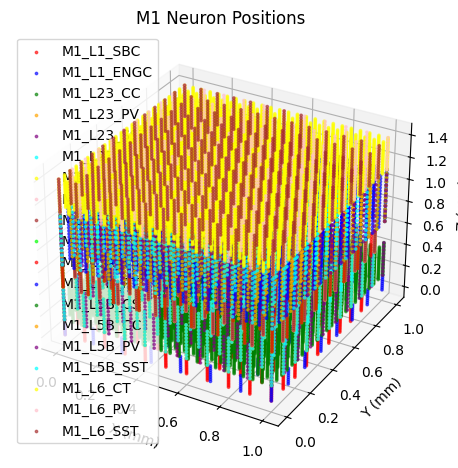

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'b', 'g', 'orange', 'purple', 'cyan', 'yellow', 'pink', 'brown', 'lime']
for i, (ntype, pos) in enumerate(layer_positions.items()):
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=3, label=ntype, alpha=0.6, color=colors[i % len(colors)])

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title('M1 Neuron Positions')
ax.legend()
plt.tight_layout()
plt.show()

In [42]:
# # convert pickle file into json file
# with open('M1_internal_connection.pickle', 'rb') as f:
#     data = pickle.load(f)


# def convert(obj):
#     if isinstance(obj, set):
#         return list(obj)
#     elif isinstance(obj, bytes):
#         return obj.decode('utf-8', errors='ignore')  # for bytes
#     # Add more conversions if needed
#     raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

# with open('M1_internal_connection.json', 'w', encoding='utf-8') as f:
#     json.dump(data, f, default=convert, indent=2, ensure_ascii=False)


In [43]:
with open('M1_internal_connection.json', 'r', encoding='utf-8') as f:
    M1_internal_connection_data = json.load(f)



In [44]:
M1_internal_connection_data['M1_L1_SBC']

{'M1_L23_CC': {'p_center': 0.0,
  'sigma': 34.349899622,
  'weight': 0.0,
  'delay': 1.5,
  'weight_distribution': 'homogeneous'},
 'M1_L5A_CS': {'p_center': 0.0,
  'sigma': 34.349899622,
  'weight': 0.0,
  'delay': 1.5,
  'weight_distribution': 'homogeneous'},
 'M1_L5A_CC': {'p_center': 0.0,
  'sigma': 34.349899622,
  'weight': 0.0,
  'delay': 1.5,
  'weight_distribution': 'homogeneous'},
 'M1_L5A_CT': {'p_center': 0.0,
  'sigma': 34.349899622,
  'weight': 0.0,
  'delay': 1.5,
  'weight_distribution': 'homogeneous'},
 'M1_L5B_CS': {'p_center': 0.0,
  'sigma': 34.349899622,
  'weight': 0.0,
  'delay': 1.5,
  'weight_distribution': 'homogeneous'},
 'M1_L5B_CC': {'p_center': 0.0,
  'sigma': 34.349899622,
  'weight': 0.0,
  'delay': 1.5,
  'weight_distribution': 'homogeneous'},
 'M1_L5B_PT': {'p_center': 0.0,
  'sigma': 34.349899622,
  'weight': 0.0,
  'delay': 1.5,
  'weight_distribution': 'homogeneous'},
 'M1_L6_CT': {'p_center': 0.0,
  'sigma': 34.349899622,
  'weight': 0.0,
  'delay':

In [45]:
# # only connect M1_L1_SBC with other nuerons
# for tgt, params in M1_internal_connection_data['M1_L1_SBC'].items():
#     if params['p_center'] != 0.0:
#         conn_spec = {
#             'rule': 'pairwise_bernoulli',
#             # 'p': nest.spatial_distributions.gaussian(nest.spatial.distance, std=params['sigma']),
#             'p':  params['p_center'] * nest.spatial_distributions.gaussian(nest.spatial.distance, std=params['sigma']),

#             # 'p': params['p_center']

#         }
#         syn_spec = {
#             'synapse_model': 'stdp_synapse',
#             'weight': params['weight'],
#             'delay': params['delay']}
#         nest.Connect(layer_neurons['M1_L1_SBC'], layer_neurons[tgt], conn_spec,syn_spec)

In [46]:
# for tgt, params in M1_internal_connection_data['M1_L1_ENGC'].items():
#     if params['p_center'] != 0.0:
#         conn_spec = {
#             'rule': 'pairwise_bernoulli',
#             # 'p': nest.spatial_distributions.gaussian(nest.spatial.distance, std=params['sigma']),
#             'p':  params['p_center'] * nest.spatial_distributions.gaussian(nest.spatial.distance, std=params['sigma']),

#             # 'p': params['p_center']

#         }
#         syn_spec = {
#             'synapse_model': 'stdp_synapse',
#             'weight': params['weight'],
#             'delay': params['delay']}
#         nest.Connect(layer_neurons['M1_L1_SBC'], layer_neurons[tgt], conn_spec,syn_spec)

In [47]:
for pre, post_info in M1_internal_connection_data.items():
    for tgt, params in post_info.items():
        sigma_x = params['sigma']
        sigma_y = params['sigma']
        conn_spec = {
            'rule': 'pairwise_bernoulli',
            # 'p':  params['p_center'] * nest.spatial_distributions.gaussian(nest.spatial.distance, std=params['sigma']),
            'p': params['p_center'] * nest.spatial_distributions.gaussian2D(
                     nest.spatial.distance.x, nest.spatial.distance.y, std_x=sigma_x, std_y=sigma_y),
        }
        syn_spec = {
            'synapse_model': 'stdp_synapse',
            'weight': params['weight'],
            'delay': params['delay']}
        nest.Connect(layer_neurons[pre], layer_neurons[tgt], conn_spec,syn_spec)

In [48]:
connectivity = nest.GetConnections(layer_neurons['M1_L1_SBC'][1])

g = connectivity.get(["source", "target", "weight"])
srcs = g["source"]
tgts = g["target"]
weights = g["weight"]


In [49]:
layer_neurons.keys()

dict_keys(['M1_L1_SBC', 'M1_L1_ENGC', 'M1_L23_CC', 'M1_L23_PV', 'M1_L23_SST', 'M1_L23_VIP', 'M1_L5A_CS', 'M1_L5A_CC', 'M1_L5A_CT', 'M1_L5A_PV', 'M1_L5A_SST', 'M1_L5B_PT', 'M1_L5B_CS', 'M1_L5B_CC', 'M1_L5B_PV', 'M1_L5B_SST', 'M1_L6_CT', 'M1_L6_PV', 'M1_L6_SST'])

In [50]:
# len(srcs)
# len(tgts)
len(weights)

1307

In [51]:
def get_neuron_position(neuron_id):
    # print(neuron_id)
    # first_id = 0
    for neuron_model, neurons in layer_neurons.items():
        if neuron_id in neurons:
            neuron_ids = layer_neurons[neuron_model].tolist()
            first = neuron_ids[0]
            id = int(neuron_id)-int(first)
            return layer_positions[neuron_model][id]


In [52]:
layer_neurons['M1_L23_CC']
# Get all neuron IDs as a list
neuron_ids = layer_neurons['M1_L23_CC'].tolist()

# Extract the first and last ID
first = neuron_ids[0]
last = neuron_ids[-1]

print(f"First Neuron ID: {first}, Last Neuron ID: {last}")


First Neuron ID: 1700, Last Neuron ID: 15523


In [53]:

fig = go.Figure()


# Add neurons as scatter points
for model_name, positions in layer_positions.items():
    fig.add_trace(go.Scatter3d(
        x=positions[:, 0], y=positions[:, 1], z=positions[:, 2],
        mode='markers',
        marker=dict(size=3, opacity=0.8),
        name=f'{model_name}'
    ))

for i in range(len(srcs)):
    src_pos = get_neuron_position(srcs[i])
    tgt_pos = get_neuron_position(tgts[i])

    if src_pos is not None and tgt_pos is not None:
        fig.add_trace(go.Scatter3d(
            x=[src_pos[0], tgt_pos[0]], 
            y=[src_pos[1], tgt_pos[1]], 
            z=[src_pos[2], tgt_pos[2]],
            mode='lines',
            line=dict(color='blue', width=1),
            opacity=0.5
        ))

In [54]:
fig.update_layout(title="3D Neural Connectivity Visualization",
                  scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"))
fig.show()

In [55]:
poisson_generator = nest.Create('poisson_generator')

In [56]:
poisson_generator.get()

{'element_type': 'stimulator',
 'frozen': False,
 'global_id': 56937,
 'label': '',
 'local': True,
 'model': 'poisson_generator',
 'model_id': 6,
 'node_uses_wfr': False,
 'origin': 0.0,
 'rate': 0.0,
 'start': 0.0,
 'stimulus_source': '0',
 'stop': 1.7976931348623157e+308,
 'thread': 0,
 'thread_local_id': -1,
 'vp': 0}

In [57]:

# nest.Connect(parrot, layer_exc)


In [58]:
poisson_frequency = 1800.0

for model_name, neurons in layer_neurons.items():
    pg = nest.Create('poisson_generator', params={'rate': poisson_frequency})

    # parrot = nest.Create('parrot_neuron')
    # nest.Connect(pg, parrot)
    nest.Connect(pg, neurons)


Apr 06 11:51:17 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.


In [59]:
multimeter = nest.Create("multimeter")
multimeter.set(record_from=["V_m"]) 
nest.Connect(multimeter, layer_neurons['M1_L23_CC'][1800])

spikerecorder_l1 = nest.Create("spike_recorder")
spikerecorder_l23 = nest.Create("spike_recorder")
spikerecorder_l5a = nest.Create("spike_recorder")
spikerecorder_l5b = nest.Create("spike_recorder")
spikerecorder_l6 = nest.Create("spike_recorder")

nest.Connect(layer_neurons['M1_L23_CC'], spikerecorder_l23)
nest.Connect(layer_neurons['M1_L23_CC'], spikerecorder_l23)


layers = ['M1_L1_SBC', 'M1_L1_ENGC', 'M1_L23_CC', 'M1_L23_PV', 'M1_L23_SST', 'M1_L23_VIP', 'M1_L5A_CS', 'M1_L5A_CC', 'M1_L5A_CT', 'M1_L5A_PV', 'M1_L5A_SST', 'M1_L5B_PT', 'M1_L5B_CS', 'M1_L5B_CC', 'M1_L5B_PV', 'M1_L5B_SST', 'M1_L6_CT', 'M1_L6_PV', 'M1_L6_SST']

spike_recorders = {layer: nest.Create("spike_recorder") for layer in layers}

for layer in layers:
    nest.Connect(layer_neurons[layer], spike_recorders[layer])

In [60]:
layer_neurons['M1_L23_CC'][1800]

NodeCollection(metadata=spatial,
               model=M1_L23_CC, size=1, first=3500, last=3500)

In [61]:
nest.Simulate(1000.0)


Apr 06 11:51:18 NodeManager::prepare_nodes [Info]: 
    Preparing 57386 nodes for simulation.

Apr 06 11:51:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 57386
    Simulation time (ms): 1000
    Number of OpenMP threads: 10
    Not using MPI

Apr 06 11:51:45 SimulationManager::run [Info]: 
    Simulation finished.


In [62]:
dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]

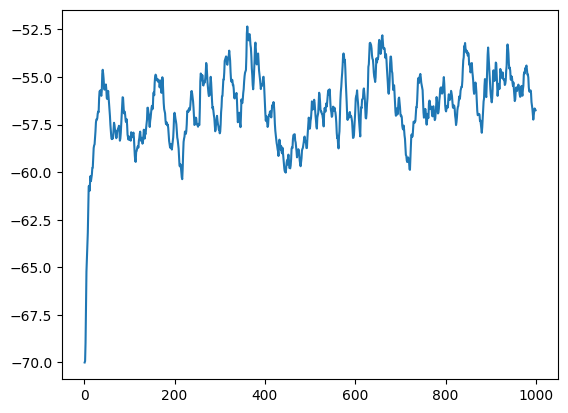

In [63]:
plt.figure(1)
plt.plot(ts, Vms)

# output_path = f'Mean_multimeter_{poisson_frequency}.png' 
# plt.savefig(output_path, format="png", dpi=300)  
# print(f"Figure saved to {output_path}")

In [64]:
# events = spikerecorder.get("events")
# senders = events["senders"]
# ts = events["times"]
# plt.figure(2)
# plt.plot(ts, senders, ".")
# plt.show()

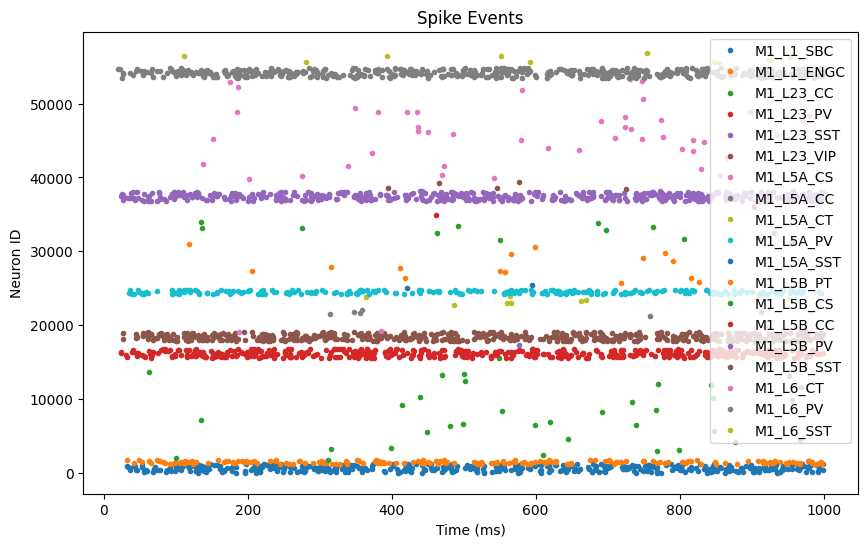

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for layer, recorder in spike_recorders.items():
    events = recorder.get("events")
    senders = events["senders"]
    ts = events["times"]
    plt.plot(ts, senders, ".", label=layer)  


plt.title("Spike Events")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron ID")
plt.legend(loc="upper right") 



# output_path = f'Mean_Spike_{poisson_frequency}.png' 
# plt.savefig(output_path, format="png", dpi=300)  
# print(f"Figure saved to {output_path}")


plt.show()

In [66]:
import numpy as np

start_time = 400.0
end_time = 1000.0


simulation_time = end_time - start_time  

spike_frequencies = {}
neuron_types = {}

for layer, neurons in ctxM1Params['M1']['neuro_info'].items():
    for neuron_type, params in neurons.items():
        neuron_types[f'M1_{layer}_{neuron_type}'] = params['EorI']

for layer, recorder in spike_recorders.items():
   
    events = recorder.get("events")
    senders = events["senders"]
    times = events["times"]
    
    mask = (times >= start_time) & (times <= end_time)
    filtered_senders = senders[mask]
    
    unique_senders, spike_counts = np.unique(filtered_senders, return_counts=True)
    
    frequencies = spike_counts / (simulation_time / 1000.0)  
    
    spike_frequencies[layer] = {
        "mean_frequency": np.mean(frequencies),
        "frequencies": dict(zip(unique_senders, frequencies))  
    }

print("Poisson Frequencies:", poisson_frequency)
for layer, data in spike_frequencies.items():
    print(f"Layer: {layer}, {neuron_types.get(layer)}, Mean Spike Frequency: {data['mean_frequency']:.2f} Hz")


Poisson Frequencies: 1800.0
Layer: M1_L1_SBC, I, Mean Spike Frequency: 1.83 Hz
Layer: M1_L1_ENGC, I, Mean Spike Frequency: 1.79 Hz
Layer: M1_L23_CC, E, Mean Spike Frequency: 1.67 Hz
Layer: M1_L23_PV, I, Mean Spike Frequency: 1.77 Hz
Layer: M1_L23_SST, I, Mean Spike Frequency: 1.67 Hz
Layer: M1_L23_VIP, I, Mean Spike Frequency: 1.85 Hz
Layer: M1_L5A_CS, E, Mean Spike Frequency: 1.67 Hz
Layer: M1_L5A_CC, E, Mean Spike Frequency: 1.67 Hz
Layer: M1_L5A_CT, E, Mean Spike Frequency: 1.67 Hz
Layer: M1_L5A_PV, I, Mean Spike Frequency: 1.85 Hz
Layer: M1_L5A_SST, I, Mean Spike Frequency: 1.67 Hz
Layer: M1_L5B_PT, E, Mean Spike Frequency: 1.67 Hz
Layer: M1_L5B_CS, E, Mean Spike Frequency: 1.67 Hz
Layer: M1_L5B_CC, E, Mean Spike Frequency: 1.67 Hz
Layer: M1_L5B_PV, I, Mean Spike Frequency: 1.80 Hz
Layer: M1_L5B_SST, I, Mean Spike Frequency: 1.67 Hz
Layer: M1_L6_CT, E, Mean Spike Frequency: 1.67 Hz
Layer: M1_L6_PV, I, Mean Spike Frequency: 1.91 Hz
Layer: M1_L6_SST, I, Mean Spike Frequency: 1.67 Hz
